In [1]:
import scanpy as sc
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
from scipy.stats import beta
import pandas as pd
import os
from scipy import sparse
import multiprocessing as mp
from functools import partial
import time

In [2]:
# Load dataset
adata = sc.read_h5ad("../../resources/GSE158067/adata_GSE158067.h5ad")
target_tf_name = "DNMT3A"

In [3]:
# Extract wildtype expression matrix and gene names
adata_wildtype = adata[adata.obs["genotype"] == "Wild-type"].copy()
adata_wildtype.var.loc[target_tf_name, "highly_variable"] = True
data_wildtype = adata_wildtype[:, adata_wildtype.var["highly_variable"]].copy()

# Use log-normalized data for GRN inference
X = (
    adata_wildtype.layers["log_normalized"].toarray()
    if hasattr(adata_wildtype.layers["log_normalized"], "toarray")
    else adata_wildtype.layers["log_normalized"]
)
genes = list(adata_wildtype.var_names)

target_tf_index = genes.index(target_tf_name)

print(f"Wildtype cells: {adata_wildtype.shape[0]}, Genes: {len(genes)}")

Wildtype cells: 231, Genes: 36591


In [4]:
adata_wildtype

AnnData object with n_obs × n_vars = 231 × 36591
    obs: 'perturbation', 'genotype', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'genotype_colors', 'hvg', 'log1p'
    layers: 'log_normalized', 'log_normalized_scaled', 'normalized'

In [5]:
# Parallel Gene Regulatory Network (GRN) Inference
def train_single_rf_model(target_gene_idx, expression_matrix, num_trees, random_seed):
    """
    Train a single Random Forest model for one target gene.
    This function is designed to be called in parallel.
    """
    target_expression = expression_matrix[:, target_gene_idx]

    # Train Random Forest regressor
    random_forest = RandomForestRegressor(
        n_estimators=num_trees,
        n_jobs=1,  # Use 1 job per process to avoid nested parallelization
        random_state=random_seed + target_gene_idx,  # Ensure different seeds
    )
    random_forest.fit(expression_matrix, target_expression)

    return target_gene_idx, random_forest.feature_importances_


def infer_GRN_parallel(
    expression_matrix, num_trees=50, random_seed=0, n_processes=None
):
    """
    Parallel version of GRN inference using multiprocessing with progress monitoring.

    Parameters:
    - expression_matrix: Gene expression matrix (cells x genes)
    - num_trees: Number of trees in each Random Forest
    - random_seed: Random seed for reproducibility
    - n_processes: Number of processes to use (None = auto-detect)
    """
    num_cells, num_genes = expression_matrix.shape
    adjacency_matrix = np.zeros((num_genes, num_genes))

    if n_processes is None:
        n_processes = min(mp.cpu_count(), num_genes)

    print(f"Using {n_processes} processes for parallel GRN inference...")
    print(f"Training Random Forest models for {num_genes} genes...")

    # Create partial function with fixed parameters
    train_func = partial(
        train_single_rf_model,
        expression_matrix=expression_matrix,
        num_trees=num_trees,
        random_seed=random_seed,
    )

    start_time = time.time()

    # Use multiprocessing with progress monitoring
    with mp.Pool(processes=n_processes) as pool:
        # Use imap instead of map to get results as they complete
        results_iter = pool.imap(train_func, range(num_genes))

        # Collect results with progress bar
        results = []
        for result in tqdm(results_iter, total=num_genes, desc="Training RF models"):
            results.append(result)

    # Collect results into adjacency matrix
    for target_gene_idx, feature_importances in results:
        adjacency_matrix[:, target_gene_idx] = feature_importances

    end_time = time.time()
    print(f"Parallel GRN inference completed in {end_time - start_time:.2f} seconds")

    return adjacency_matrix

In [6]:
grn_file_h5ad = f"../../results/grn_output/grn_adjacency_matrix_{target_tf_name}.h5ad"

In [7]:
# # Parallel GRN Inference
# print("Inferring gene regulatory network using parallel processing...")

# # Run parallel GRN inference
# gene_regulatory_network = infer_GRN_parallel(
#     X,
#     num_trees=50,
#     random_seed=0,
#     n_processes=None,  # Auto-detect optimal number of processes
# )

# print(f"GRN inferred with shape: {gene_regulatory_network.shape}")

# # Display basic network statistics
# non_zero_edges = np.count_nonzero(gene_regulatory_network)
# total_possible_edges = gene_regulatory_network.size
# sparsity = (non_zero_edges / total_possible_edges) * 100

# print(f"Network statistics:")
# print(f"  - Non-zero edges: {non_zero_edges:,}")
# print(f"  - Network sparsity: {sparsity:.2f}%")
# print(f"  - Max edge weight: {gene_regulatory_network.max():.6f}")

# # Create output directory if it doesn't exist
# output_dir = "../../results/grn_output"
# os.makedirs(output_dir, exist_ok=True)

# # Convert to sparse matrix for efficient storage
# grn_sparse = sparse.csr_matrix(gene_regulatory_network)

# # Create AnnData object where:
# # - X contains the GRN adjacency matrix
# # - obs (observations) represent source genes
# # - var (variables) represent target genes
# grn_adata = sc.AnnData(
#     X=grn_sparse, obs=pd.DataFrame(index=genes), var=pd.DataFrame(index=genes)
# )

# # Add metadata (convert to h5ad-compatible types)
# grn_adata.uns["description"] = (
#     f"Gene regulatory network adjacency matrix for {target_tf_name} perturbation"
# )
# grn_adata.uns["target_tf"] = target_tf_name
# grn_adata.uns["matrix_shape"] = list(
#     gene_regulatory_network.shape
# )  # Convert tuple to list
# grn_adata.uns["inference_method"] = "Random Forest"
# grn_adata.uns["n_genes"] = int(len(genes))  # Ensure it's a standard int

# # Save as h5ad file
# grn_adata.write(grn_file_h5ad)
# print(f"GRN adjacency matrix saved as AnnData h5ad file: {grn_file_h5ad}")

# print(f"\nMatrix shape: {gene_regulatory_network.shape}")
# print(f"Number of genes: {len(genes)}")
# print(f"Sparsity: {(grn_sparse.nnz / grn_sparse.size) * 100:.2f}% non-zero values")
# print(f"File size reduction: sparse matrix is much more efficient for storage")

In [8]:
# Load and verify the saved GRN matrix
loaded_grn_adata = sc.read_h5ad(grn_file_h5ad)
gene_regulatory_network = loaded_grn_adata.X.toarray()

In [9]:
import networkx as nx
from itertools import islice


def _best_gn_partition(G, target_num_communities=None, max_splits=50):
    """
    Run Girvan–Newman and return the partition with either:
      - the requested number of communities, or
      - the highest modularity seen within the first `max_splits` splits.
    """
    from networkx.algorithms.community import girvan_newman, modularity

    comp_gen = girvan_newman(G)
    best_part, best_mod = None, -1.0

    for i, communities in enumerate(islice(comp_gen, max_splits)):
        partition = tuple(sorted(sorted(c) for c in communities))
        if (
            target_num_communities is not None
            and len(partition) == target_num_communities
        ):
            return [set(c) for c in partition]
        # track best modularity so far
        m = modularity(G, communities, weight="weight")
        if m > best_mod:
            best_mod, best_part = m, [set(c) for c in partition]

    return best_part


def _renormalize_rows(mat):
    rs = mat.sum(axis=1, keepdims=True)
    rs[rs == 0] = 1
    return mat / rs


def prune_transition_matrix(
    transition_matrix,
    prune_method,
    # threshold method params
    threshold=0.01,
    # top_k method params
    top_k=5,
    # disparity filter params
    alpha=0.05,
    # centrality-based pruning params
    centrality_threshold=0.1,
    # top_genes method params
    top_n_genes=200,
    # --- NEW: community detection params ---
    cd_method="girvan_newman",
    target_num_communities=None,  # e.g., 5; if None, picks best modularity
    max_splits=50,  # how many GN splits to consider
    use_abs_weights=True,  # use abs(weights) when building community graph
    min_weight=0.0,  # ignore edges below this when building the graph
    inter_strategy="remove",  # "remove" | "keep_ratio"
    inter_keep_ratio=0.0,  # if "keep_ratio", keep this fraction of strongest inter edges per row
    intra_top_k=None,  # cap kept intra-community edges per row (None disables)
    renormalize=True,  # re-normalize rows after pruning
):
    """
    Prunes edges from a transition matrix using different methods, including community detection.

    Community detection (Girvan–Newman) knobs:
      - cd_method: currently only 'girvan_newman' supported
      - target_num_communities: force a specific # of communities; if None, choose partition with best modularity
      - max_splits: search depth for GN
      - use_abs_weights: use |w| when forming the undirected graph for community detection
      - min_weight: drop edges below this when forming the community graph
      - inter_strategy: 'remove' to drop all inter-community edges, or 'keep_ratio' to keep a fraction per row
      - inter_keep_ratio: fraction of strongest inter edges to retain per row if inter_strategy='keep_ratio'
      - intra_top_k: keep at most K strongest intra-community edges per row (None = keep all)
      - renormalize: L1 re-normalize rows post-pruning
    """
    import numpy as np
    import networkx as nx
    from scipy.stats import beta

    def compute_centrality_measures(transition_matrix):
        G = nx.from_numpy_array(transition_matrix, create_using=nx.DiGraph)
        degree = nx.degree_centrality(G)
        closeness = nx.closeness_centrality(
            G, distance=None
        )  # treat weights as strengths, not distances
        betweenness = nx.betweenness_centrality(G, weight="weight")
        return degree, closeness, betweenness

    if prune_method == "no pruning":
        return transition_matrix

    elif prune_method == "top_genes":
        gene_strengths = np.sum(np.abs(transition_matrix), axis=1) + np.sum(
            np.abs(transition_matrix), axis=0
        )
        top_gene_indices = np.argsort(gene_strengths)[-top_n_genes:]
        pruned_matrix = np.zeros_like(transition_matrix)
        pruned_matrix[np.ix_(top_gene_indices, top_gene_indices)] = transition_matrix[
            np.ix_(top_gene_indices, top_gene_indices)
        ]

    elif prune_method == "threshold":
        pruned_matrix = np.where(
            np.abs(transition_matrix) >= threshold, transition_matrix, 0
        )

    elif prune_method == "top_k":
        pruned_matrix = np.zeros_like(transition_matrix)
        for i in range(transition_matrix.shape[0]):
            row = transition_matrix[i, :]
            k = min(top_k, row.size)
            idx = np.argpartition(-np.abs(row), k - 1)[:k]
            pruned_matrix[i, idx] = row[idx]

    elif prune_method == "disparity":
        n = transition_matrix.shape[0]
        pruned_matrix = np.zeros_like(transition_matrix)
        abs_matrix = np.abs(transition_matrix)
        strengths = np.sum(abs_matrix, axis=1, keepdims=True)
        nonzero_counts = np.count_nonzero(abs_matrix, axis=1, keepdims=True)
        mask_nonzero_strength = strengths > 0

        for i in range(n):
            if not mask_nonzero_strength[i, 0]:
                continue
            row = abs_matrix[i, :]
            strength = strengths[i, 0]
            k = int(nonzero_counts[i, 0])
            if k == 0:
                continue
            nz = row > 0
            p_ij = row[nz] / strength
            alpha_ij = 1 - (k - 1) * beta.cdf(p_ij, 1, k - 1)
            keep_mask = alpha_ij < alpha
            keep_idx = np.where(nz)[0][keep_mask]
            pruned_matrix[i, keep_idx] = transition_matrix[i, keep_idx]

    elif prune_method == "degree_centrality":
        degree, _, _ = compute_centrality_measures(transition_matrix)
        pruned_matrix = np.zeros_like(transition_matrix)
        for i in range(transition_matrix.shape[0]):
            if degree.get(i, 0) >= centrality_threshold:
                pruned_matrix[i, :] = transition_matrix[i, :]

    elif prune_method == "closeness_centrality":
        _, closeness, _ = compute_centrality_measures(transition_matrix)
        pruned_matrix = np.zeros_like(transition_matrix)
        for i in range(transition_matrix.shape[0]):
            if closeness.get(i, 0) >= centrality_threshold:
                pruned_matrix[i, :] = transition_matrix[i, :]

    elif prune_method == "betweenness_centrality":
        _, _, betweenness = compute_centrality_measures(transition_matrix)
        pruned_matrix = np.zeros_like(transition_matrix)
        for i in range(transition_matrix.shape[0]):
            if betweenness.get(i, 0) >= centrality_threshold:
                pruned_matrix[i, :] = transition_matrix[i, :]

    elif prune_method == "community_detection":
        # 1) Build undirected weighted graph for community detection
        W = np.abs(transition_matrix) if use_abs_weights else transition_matrix.copy()
        if min_weight > 0:
            W = np.where(W >= min_weight, W, 0.0)

        # symmetrize for community detection
        W_sym = np.maximum(W, W.T)
        G = nx.from_numpy_array(W_sym)  # undirected, weight in 'weight'
        # remove zero-weight edges to keep GN happy
        G.remove_edges_from(
            [(u, v) for u, v, d in G.edges(data=True) if d.get("weight", 0.0) <= 0.0]
        )

        if G.number_of_edges() == 0:
            pruned_matrix = np.zeros_like(transition_matrix)
        else:
            if cd_method != "girvan_newman":
                raise ValueError("Only 'girvan_newman' is supported currently.")
            communities = _best_gn_partition(G, target_num_communities, max_splits)
            # node -> community id
            node2c = {}
            for cid, cset in enumerate(communities):
                for node in cset:
                    node2c[node] = cid

            # 2) Prune based on community structure
            pruned_matrix = np.zeros_like(transition_matrix)

            n = transition_matrix.shape[0]
            for i in range(n):
                row = transition_matrix[i, :]

                # split indices by intra/inter relative to i's community
                ci = node2c.get(i, -1)
                intra_idx = [j for j in range(n) if node2c.get(j, -2) == ci]
                inter_idx = [j for j in range(n) if node2c.get(j, -2) != ci]

                # Intra: optionally cap top-K by strength
                if intra_top_k is None or intra_top_k >= len(intra_idx):
                    pruned_matrix[i, intra_idx] = row[intra_idx]
                else:
                    k = max(0, int(intra_top_k))
                    if k > 0:
                        intra_vals = np.abs(row[intra_idx])
                        keep_local = np.argpartition(-intra_vals, k - 1)[:k]
                        keep_idx = [intra_idx[t] for t in keep_local]
                        pruned_matrix[i, keep_idx] = row[keep_idx]

                # Inter: drop or keep a fraction of strongest
                if inter_strategy == "remove":
                    pass  # keep zeros
                elif inter_strategy == "keep_ratio":
                    frac = float(inter_keep_ratio)
                    if 0.0 < frac <= 1.0 and len(inter_idx) > 0:
                        k = max(1, int(np.ceil(frac * len(inter_idx))))
                        inter_vals = np.abs(row[inter_idx])
                        keep_local = np.argpartition(
                            -inter_vals, min(k - 1, len(inter_vals) - 1)
                        )[:k]
                        keep_idx = [inter_idx[t] for t in keep_local]
                        pruned_matrix[i, keep_idx] = row[keep_idx]
                else:
                    raise ValueError("inter_strategy must be 'remove' or 'keep_ratio'.")

    else:
        raise ValueError(f"Unknown pruning method: {prune_method}")

    # Optional row re-normalization to keep a valid transition matrix
    if renormalize:
        pruned_matrix = _renormalize_rows(pruned_matrix)

    return pruned_matrix

In [10]:
def normalize_adjacency_matrix(adjacency_matrix):
    row_sums = adjacency_matrix.sum(axis=1, keepdims=True)
    # Avoid division by zero for genes with no outgoing edges
    row_sums[row_sums == 0] = 1
    transition_matrix = adjacency_matrix / row_sums
    return transition_matrix


def simulate_tf_perturbation(
    adjacency_matrix,
    tf_gene_index,
    perturbation_strength=1.0,
    damping_factor=0.85,
    convergence_tolerance=1e-6,
    max_iterations=100,
    prune_method="threshold",
    prune_params={},
):
    num_genes = adjacency_matrix.shape[0]

    # Initialize perturbation vector (only the TF is initially perturbed)
    initial_perturbation = np.zeros(num_genes)
    initial_perturbation[tf_gene_index] = perturbation_strength

    # Create transition matrix (transpose for correct direction of influence)
    transition_matrix = normalize_adjacency_matrix(adjacency_matrix).T

    transition_matrix = prune_transition_matrix(
        transition_matrix, prune_method, **prune_params
    )

    # Initialize current perturbation state
    current_perturbation = initial_perturbation.copy()

    # Iterative damped propagation
    for iteration in tqdm(
        range(max_iterations), desc="Simulating perturbation propagation"
    ):
        # Propagate through network
        propagated = transition_matrix @ current_perturbation

        # Combine propagated signal with source retention
        next_perturbation = damping_factor * propagated
        next_perturbation[tf_gene_index] += (1 - damping_factor) * perturbation_strength

        # Check for convergence
        perturbation_change = np.linalg.norm(
            next_perturbation - current_perturbation, ord=1
        )
        if perturbation_change < convergence_tolerance:
            break

        current_perturbation = next_perturbation

    return current_perturbation

In [11]:
# Define pruning methods to compare - using top_genes method to get exactly ~200 genes
print(f"Network shape: {gene_regulatory_network.shape}")
print(f"Total edges: {np.count_nonzero(gene_regulatory_network):,}")
print(f"Max edge weight: {gene_regulatory_network.max():.6f}")

# Calculate gene strengths to see distribution
gene_strengths = np.sum(np.abs(gene_regulatory_network), axis=1) + np.sum(
    np.abs(gene_regulatory_network), axis=0
)
print(f"Gene strength - 95th percentile: {np.percentile(gene_strengths, 95):.4f}")
print(f"Gene strength - 99th percentile: {np.percentile(gene_strengths, 99):.4f}")
print(f"Top 200 gene strength threshold: {np.sort(gene_strengths)[-200]:.4f}")

pruning_methods = {
    "no_pruning": {"method": "no pruning", "params": {}},
    "girvan newmann": {
        "method": "community_detection",
        "params": {"inter_strategy": "remove", "intra_top_k": 50},
    },
}

print(f"\nComparing {len(pruning_methods)} pruning methods")
print(f"Target TF: {target_tf_name}")
print("Targeting ~200-300 genes with connections after pruning")

Network shape: (36591, 36591)
Total edges: 23,140,341
Total edges: 23,140,341
Max edge weight: 0.995361
Max edge weight: 0.995361
Gene strength - 95th percentile: 2.4990
Gene strength - 99th percentile: 2.7489
Top 200 gene strength threshold: 2.8447

Comparing 2 pruning methods
Target TF: DNMT3A
Targeting ~200-300 genes with connections after pruning
Gene strength - 95th percentile: 2.4990
Gene strength - 99th percentile: 2.7489
Top 200 gene strength threshold: 2.8447

Comparing 2 pruning methods
Target TF: DNMT3A
Targeting ~200-300 genes with connections after pruning


In [12]:
# Compute perturbation scores for each method
perturbation_results = {}


# Helper function to count genes with connections
def count_active_genes(matrix):
    """Count genes that have at least one outgoing or incoming connection"""
    outgoing = np.count_nonzero(np.sum(matrix, axis=1))
    incoming = np.count_nonzero(np.sum(matrix, axis=0))
    return max(outgoing, incoming)


for method_name, config in pruning_methods.items():
    print(f"\nComputing perturbations for: {method_name}")

    # Test the pruning first to see network size
    transition_matrix = normalize_adjacency_matrix(gene_regulatory_network).T
    pruned_matrix = prune_transition_matrix(
        transition_matrix, config["method"], **config["params"]
    )

    active_genes = count_active_genes(pruned_matrix)
    edges_remaining = np.count_nonzero(pruned_matrix)

    print(f"  Active genes after pruning: {active_genes}")
    print(f"  Edges remaining: {edges_remaining:,}")
    print(f"  Network density: {edges_remaining / pruned_matrix.size * 100:.4f}%")

    # Run perturbation simulation
    scores = simulate_tf_perturbation(
        gene_regulatory_network,
        target_tf_index,
        perturbation_strength=1.0,
        prune_method=config["method"],
        prune_params=config["params"],
    )

    # Store results
    perturbation_results[method_name] = {
        "scores": scores,
        "target_tf_score": scores[target_tf_index],
        "max_score": np.max(np.abs(scores)),
        "mean_score": np.mean(np.abs(scores)),
        "active_genes": active_genes,
        "edges_remaining": edges_remaining,
    }

print(f"\nComputed perturbations for {len(perturbation_results)} methods")


Computing perturbations for: no_pruning
  Active genes after pruning: 21723
  Edges remaining: 23,140,341
  Network density: 1.7283%
  Active genes after pruning: 21723
  Edges remaining: 23,140,341
  Network density: 1.7283%


Simulating perturbation propagation:  40%|████      | 40/100 [00:03<00:04, 12.58it/s]




Computing perturbations for: girvan newmann


KeyboardInterrupt: 

Creating network visualizations for top 5% affected genes...

Generating network visualization for: top_200_genes
Active genes in network: 148
Edges remaining: 199
Showing top 1829 genes (5% of 36591 total genes)
Network: 1829 nodes, 11883 edges


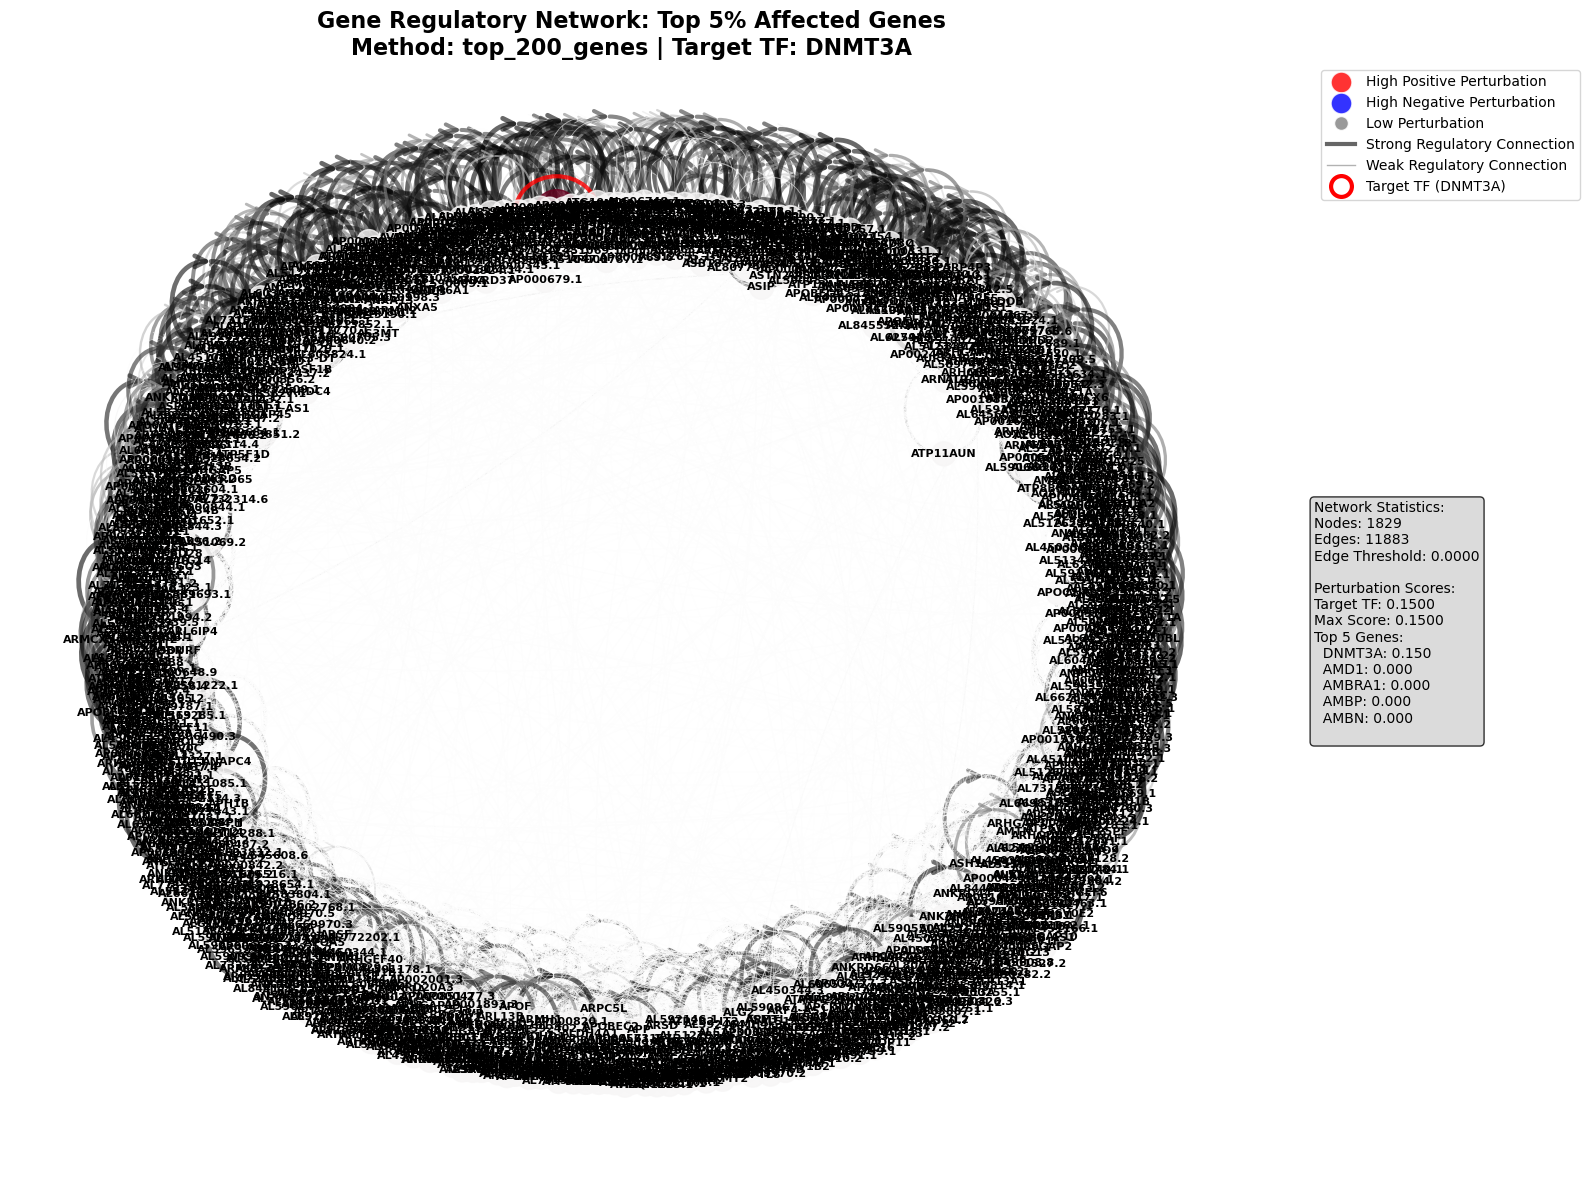


Generating network visualization for: top_300_genes
Active genes in network: 249
Edges remaining: 383
Showing top 1829 genes (5% of 36591 total genes)
Network: 1829 nodes, 11883 edges


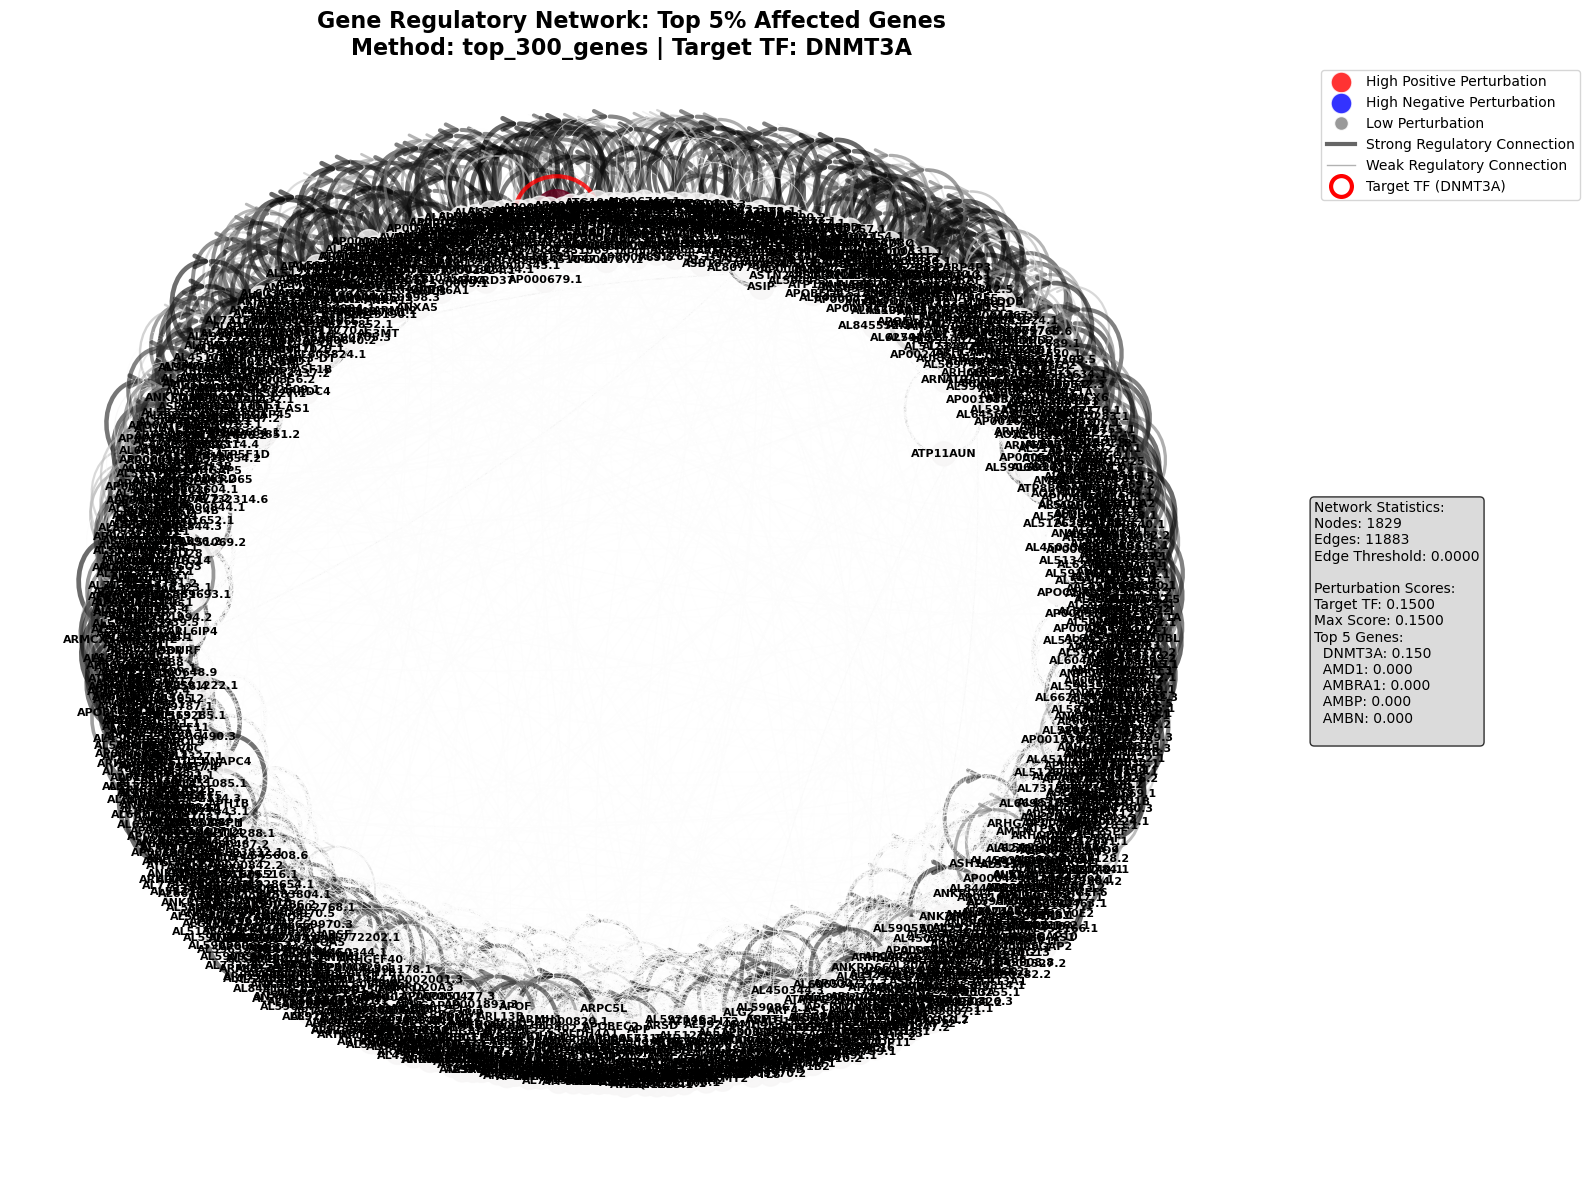


Network visualizations complete!

Visualization Features:
• Node size = perturbation magnitude
• Node color = perturbation direction (red=positive, blue=negative)
• Edge thickness = regulatory connection strength
• Edge transparency = connection weight
• Arrows = regulatory direction
• Target TF (DNMT3A) highlighted with red circle
• Only top 75th percentile edges shown to reduce clutter


In [ ]:
# Network visualization adapted for different parameter combinations
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Create network plots for each method
methods = list(perturbation_results.keys())
fig, axes = plt.subplots(1, len(methods), figsize=(18, 6), dpi=100)

# If only one method, make axes a list
if len(methods) == 1:
    axes = [axes]

for ax, method_name in zip(axes, methods):
    # Get perturbation scores for this method
    scores = perturbation_results[method_name]["scores"]

    # Create network graph
    G = nx.DiGraph()

    # Add nodes with perturbation scores
    for i, gene in enumerate(genes):
        G.add_node(gene, p=scores[i])

    # Add edges using 95th percentile threshold from original network
    thresh = np.percentile(gene_regulatory_network, 95)
    for i in range(gene_regulatory_network.shape[0]):
        for j in range(gene_regulatory_network.shape[1]):
            if i == j:
                continue
            if gene_regulatory_network[i, j] >= thresh:
                G.add_edge(genes[i], genes[j])

    # Create layout
    pos = nx.spring_layout(G, seed=42)

    # Get perturbation values for coloring
    vals = [G.nodes[n]["p"] for n in G.nodes()]

    # Draw the network
    nx.draw(
        G,
        pos,
        ax=ax,
        node_color=vals,
        cmap="coolwarm",
        with_labels=False,
        node_size=100,
        edge_color="lightgray",
    )

    # Set title
    ax.set_title(f"{method_name} perturbation ({target_tf_name})")

plt.tight_layout()
plt.show()

/var/tmp/ipykernel_77087/2658032716.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax2.boxplot(score_data, labels=methods, patch_artist=True)


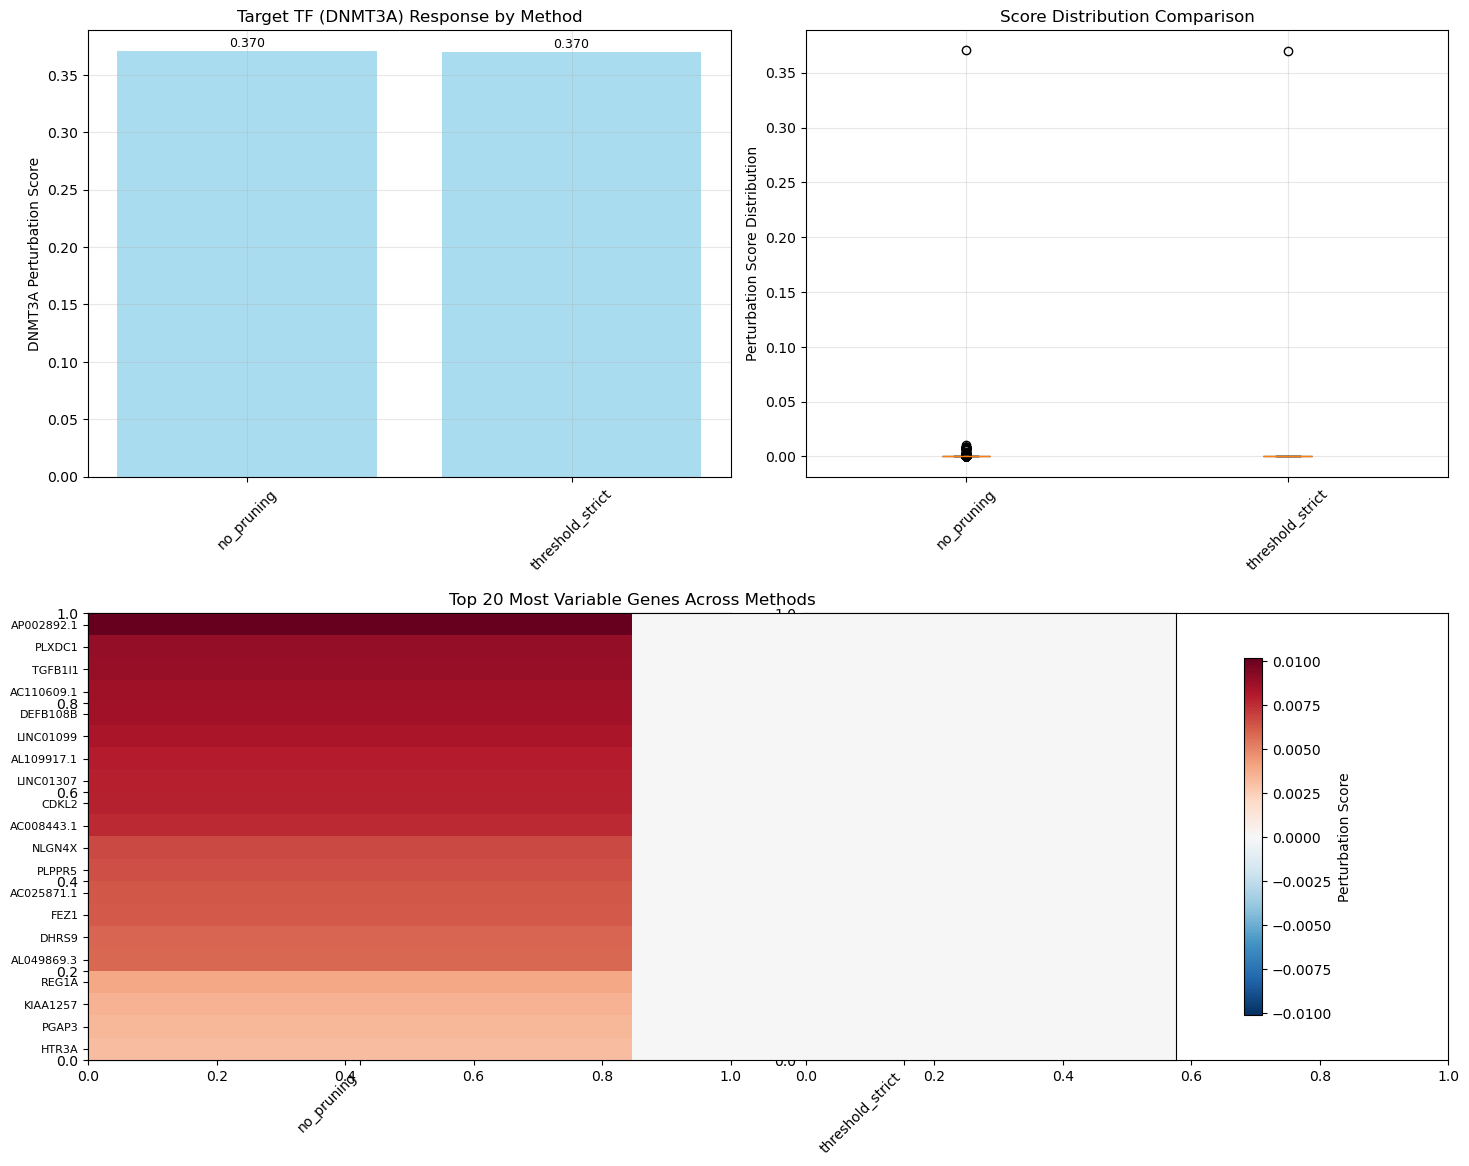

In [ ]:
# Compare perturbation distributions and top affected genes
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Target TF response comparison
ax1 = axes[0, 0]
methods = list(perturbation_results.keys())
tf_scores = [perturbation_results[m]["target_tf_score"] for m in methods]

bars = ax1.bar(methods, tf_scores, alpha=0.7, color="skyblue")
ax1.set_ylabel(f"{target_tf_name} Perturbation Score")
ax1.set_title(f"Target TF ({target_tf_name}) Response by Method")
ax1.tick_params(axis="x", rotation=45)
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars, tf_scores):
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.001,
        f"{score:.3f}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

# 2. Perturbation score distributions
ax2 = axes[0, 1]
score_data = [perturbation_results[m]["scores"] for m in methods]
box_plot = ax2.boxplot(score_data, labels=methods, patch_artist=True)

colors = plt.cm.Set3(np.linspace(0, 1, len(methods)))
for patch, color in zip(box_plot["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.set_ylabel("Perturbation Score Distribution")
ax2.set_title("Score Distribution Comparison")
ax2.tick_params(axis="x", rotation=45)
ax2.grid(True, alpha=0.3)

# 3. Top 20 affected genes heatmap - use the bottom row
# Create a new subplot spanning the bottom row
ax3 = plt.subplot(2, 1, 2)  # This creates a subplot in the bottom half
all_scores = np.column_stack([perturbation_results[m]["scores"] for m in methods])

# Find top 20 most variable genes across methods
gene_variance = np.var(all_scores, axis=1)
top_gene_indices = np.argsort(gene_variance)[::-1][:20]
top_genes = [genes[i] for i in top_gene_indices]
heatmap_data = all_scores[top_gene_indices, :]

im = ax3.imshow(
    heatmap_data,
    cmap="RdBu_r",
    aspect="auto",
    vmin=-np.max(np.abs(heatmap_data)),
    vmax=np.max(np.abs(heatmap_data)),
)

ax3.set_xticks(range(len(methods)))
ax3.set_xticklabels(methods, rotation=45, ha="right")
ax3.set_yticks(range(len(top_genes)))
ax3.set_yticklabels(top_genes, fontsize=8)
ax3.set_title("Top 20 Most Variable Genes Across Methods")

# Add colorbar
cbar = plt.colorbar(im, ax=ax3, shrink=0.8)
cbar.set_label("Perturbation Score")

plt.tight_layout()
plt.show()

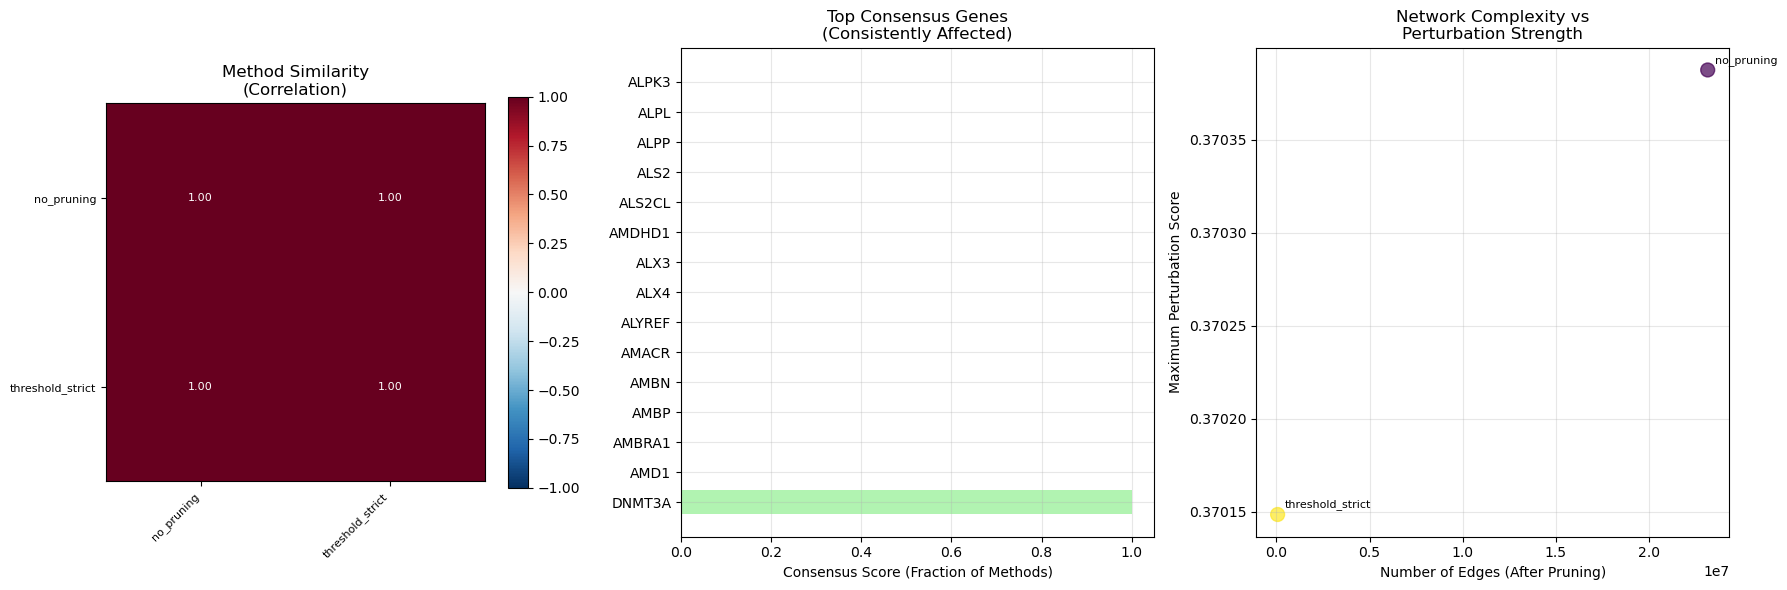


PERTURBATION ANALYSIS SUMMARY

Target TF: DNMT3A
Best method by TF response: no_pruning
Best method by max perturbation: no_pruning

Top 5 consensus genes:
  1. DNMT3A
  2. AMD1
  3. AMBRA1
  4. AMBP
  5. AMBN

Method correlations (most similar pair):
  no_pruning ↔ threshold_strict: 0.996


In [ ]:
# Method similarity and consensus analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Method correlation matrix
ax1 = axes[0]
methods = list(perturbation_results.keys())
all_scores = np.column_stack([perturbation_results[m]["scores"] for m in methods])
correlation_matrix = np.corrcoef(all_scores.T)

im1 = ax1.imshow(correlation_matrix, cmap="RdBu_r", vmin=-1, vmax=1)
ax1.set_xticks(range(len(methods)))
ax1.set_xticklabels(methods, rotation=45, ha="right", fontsize=8)
ax1.set_yticks(range(len(methods)))
ax1.set_yticklabels(methods, fontsize=8)
ax1.set_title("Method Similarity\n(Correlation)")

# Add correlation values
for i in range(len(methods)):
    for j in range(len(methods)):
        ax1.text(
            j,
            i,
            f"{correlation_matrix[i, j]:.2f}",
            ha="center",
            va="center",
            color="white" if abs(correlation_matrix[i, j]) > 0.5 else "black",
            fontsize=8,
        )

plt.colorbar(im1, ax=ax1, shrink=0.8)

# 2. Find consensus genes (consistently high across methods)
ax2 = axes[1]
# Normalize scores and find genes with high impact across multiple methods
normalized_scores = np.abs(all_scores) / np.max(np.abs(all_scores), axis=0)
consensus_scores = np.mean(
    normalized_scores > 0.5, axis=1
)  # Fraction of methods with high impact

# Get top 15 consensus genes
top_consensus_indices = np.argsort(consensus_scores)[::-1][:15]
top_consensus_genes = [genes[i] for i in top_consensus_indices]
top_consensus_values = consensus_scores[top_consensus_indices]

y_pos = np.arange(len(top_consensus_genes))
bars = ax2.barh(y_pos, top_consensus_values, alpha=0.7, color="lightgreen")
ax2.set_yticks(y_pos)
ax2.set_yticklabels(top_consensus_genes)
ax2.set_xlabel("Consensus Score (Fraction of Methods)")
ax2.set_title("Top Consensus Genes\n(Consistently Affected)")
ax2.grid(True, alpha=0.3)

# 3. Network complexity vs performance
ax3 = axes[2]
# Calculate network statistics for each method
network_stats = {}
for method_name, config in pruning_methods.items():
    transition_matrix = normalize_adjacency_matrix(gene_regulatory_network).T
    pruned_matrix = prune_transition_matrix(
        transition_matrix, config["method"], **config["params"]
    )

    n_edges = np.count_nonzero(pruned_matrix)
    max_score = perturbation_results[method_name]["max_score"]

    network_stats[method_name] = {"edges": n_edges, "max_score": max_score}

edge_counts = [network_stats[m]["edges"] for m in methods]
max_scores = [network_stats[m]["max_score"] for m in methods]

scatter = ax3.scatter(
    edge_counts, max_scores, s=100, alpha=0.7, c=range(len(methods)), cmap="viridis"
)
for i, method in enumerate(methods):
    ax3.annotate(
        method,
        (edge_counts[i], max_scores[i]),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=8,
    )

ax3.set_xlabel("Number of Edges (After Pruning)")
ax3.set_ylabel("Maximum Perturbation Score")
ax3.set_title("Network Complexity vs\nPerturbation Strength")
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print simple summary
print("\n" + "=" * 60)
print("PERTURBATION ANALYSIS SUMMARY")
print("=" * 60)

print(f"\nTarget TF: {target_tf_name}")
print(
    f"Best method by TF response: {max(methods, key=lambda m: abs(perturbation_results[m]['target_tf_score']))}"
)
print(
    f"Best method by max perturbation: {max(methods, key=lambda m: perturbation_results[m]['max_score'])}"
)

print(f"\nTop 5 consensus genes:")
for i, gene in enumerate(top_consensus_genes[:5], 1):
    print(f"  {i}. {gene}")

print(f"\nMethod correlations (most similar pair):")
max_corr = -1
best_pair = None
for i in range(len(methods)):
    for j in range(i + 1, len(methods)):
        if correlation_matrix[i, j] > max_corr:
            max_corr = correlation_matrix[i, j]
            best_pair = (methods[i], methods[j])

if best_pair:
    print(f"  {best_pair[0]} ↔ {best_pair[1]}: {max_corr:.3f}")

In [ ]:
# Save results in simple format
output_dir = "../../results/grn_output"
os.makedirs(output_dir, exist_ok=True)

# Create summary DataFrame
summary_data = []
for method in methods:
    summary_data.append({
        'Method': method,
        'Target_TF_Score': perturbation_results[method]['target_tf_score'],
        'Max_Perturbation': perturbation_results[method]['max_score'],
        'Mean_Perturbation': perturbation_results[method]['mean_score'],
        'Network_Edges': network_stats[method]['edges']
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Target_TF_Score', key=abs, ascending=False)

print("Method Comparison Summary:")
print("="*50)
print(summary_df.round(4).to_string(index=False))

# Save summary
summary_file = os.path.join(output_dir, f"perturbation_summary_{target_tf_name}.csv")
summary_df.to_csv(summary_file, index=False)

# Save perturbation matrix
perturbation_matrix = np.column_stack([perturbation_results[m]['scores'] for m in methods])
matrix_file = os.path.join(output_dir, f"perturbation_matrix_{target_tf_name}.npz")
np.savez_compressed(matrix_file, 
                   matrix=perturbation_matrix,
                   methods=methods,
                   genes=genes,
                   target_tf=target_tf_name,
                   target_tf_index=target_tf_index)

print(f"\n✓ Results saved:")
print(f"  Summary: {summary_file}")
print(f"  Matrix: {matrix_file}")

print(f"\n🎉 Analysis complete! Target TF: {target_tf_name}")
print(f"? {len(methods)} methods compared across {len(genes)} genes")